# 目的
2019/01/01 00:00 - 2019/01/07 00:00の期間について、１日ごとの最大利益を与える組 $(N_1,N_2)$ を解析し、その遷移になにかしらの意味があるのかどうかを調査する。   

## モジュールと関数の用意

In [3]:
from datetime import datetime
import glob
import itertools
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import numpy as np
import os
import pandas as pd
import pickle
# import sys
# sys.path.append("./")
from utils import *

%matplotlib inline

## データの読み込み

In [4]:
file_list = [
    "../data/ohlcv/OHLCV_201901010000_to_201901070000.csv",
]

df = None
for fpath in file_list:
    if df is None:
        df = pd.read_csv(fpath, index_col=0)
    else:
        df_ = pd.read_csv(fpath, index_col=0)
        df = pd.concat((df, df_))
df.head()

,time,id_start,open,high,low,close,volume
0,1.546236e+09,694426164,419209,421060,419022,419732,350
1,1.546236e+09,694427312,419898,422592,418124,419352,1000
2,1.546236e+09,694430055,419352,419727,416443,416697,779
3,1.546236e+09,694433381,416443,417700,409500,413668,2184
4,1.546236e+09,694437582,410638,417000,410612,414100,1281


In [5]:
df.tail()

,time,id_start,open,high,low,close,volume
8636,1.546754e+09,707782203,414465,414504,414245,414324,66
8637,1.546754e+09,707784345,414351,414497,414229,414295,61
8638,1.546754e+09,707786284,414273,414427,414251,414324,50
8639,1.546754e+09,707788206,414340,414529,414256,414412,51
8640,1.546754e+09,707790030,414412,414531,414363,414383,38


In [6]:
len(df)

8641

## 前回の計算結果の読み込み

In [7]:
with open("../data/analysis_of_ohlc(20190101-20190107)-2_res.pickle", "rb") as ff:
    results = pickle.load(ff)

results.keys()

dict_keys(['results_list', 'results_list_best', 'N_max', 'comb_list', 'benefits_list', 'benefits_list_best', 'benefits_2d', 'benefits_best_2d', 'ary'])

## benefitsの取り出し

In [8]:
span = 24*60 # 1 day
N_span = len(df) // span
if N_span * span == len(df):
    periods = N_span
else:
    periods = N_span + 1

comb_list = results["comb_list"]
results_main_list = results["results_list"]

N_max = results["N_max"]
benefits_main_period = np.zeros((periods, N_max + 1, N_max + 1, 2), dtype=int)

for jj in range(len(comb_list)):
    x, y = comb_list[jj]
    results_main = results_main_list[jj]
    a_k = results_main["a_k"]
    benefits = results_main["benefits"]
    for ii in range(periods):
        start = ii * span
        if ii == periods - 1:
            end = len(df)
        else:
            end = (ii + 1) * span
        
        index = (a_k[:, 0] >= start) & (a_k[:, 0] < end)
        benefits_main_period[ii, x, y, 0] = -((benefits[index])[a_k[index, 1] == -1]).sum() # dead
        benefits_main_period[ii, x, y, 1] = ((benefits[index])[a_k[index, 1] ==  1]).sum() # golden

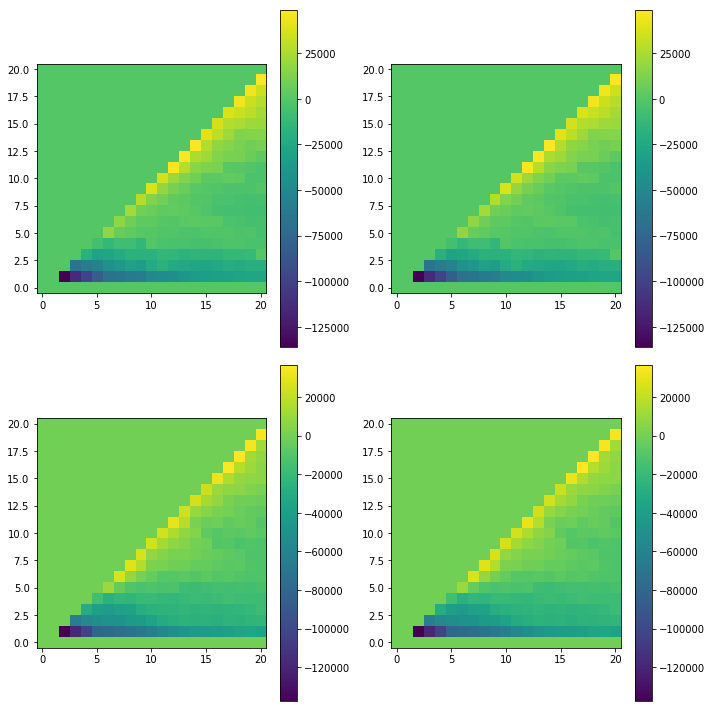

In [9]:
benefits_2d = results["benefits_2d"]

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(benefits_main_period[:, :, :, 0].sum(axis=0), origin="normal")
plt.colorbar()
plt.subplot(222)
plt.imshow(benefits_2d[:, :, 0], origin="normal")
plt.colorbar()
plt.subplot(223)
plt.imshow(benefits_main_period[:, :, :, 1].sum(axis=0), origin="normal")
plt.colorbar()
plt.subplot(224)
plt.imshow(benefits_2d[:, :, 1], origin="normal")
plt.colorbar()

plt.tight_layout()

In [10]:
print(np.where(benefits_2d.sum(axis=2)==benefits_2d.sum(axis=2).max()), benefits_2d.sum(axis=2).max())

(array([19], dtype=int64), array([20], dtype=int64)) 82911


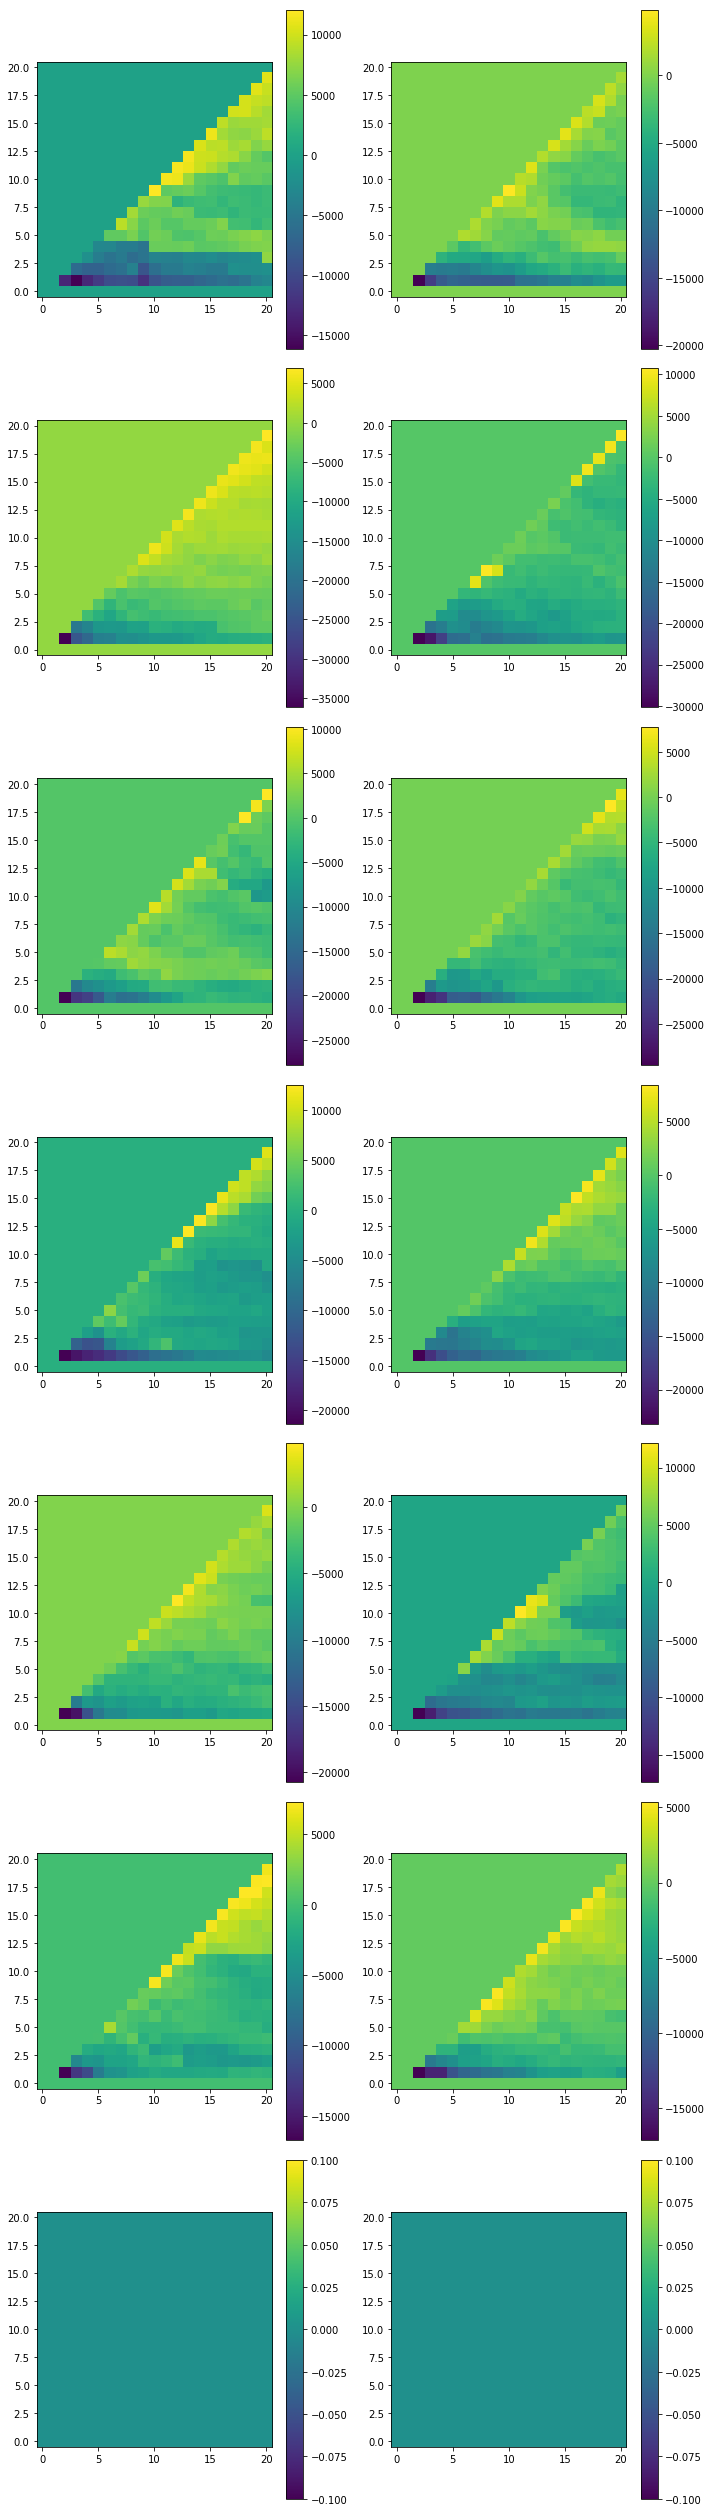

In [11]:
plt.figure(figsize=(10, benefits_main_period.shape[0]*5))

for ii in range(benefits_main_period.shape[0]):
    plt.subplot(benefits_main_period.shape[0], 2, 2 * ii + 1)
    plt.imshow(benefits_main_period[ii, :, :, 0], origin="normal")
    plt.colorbar()
    plt.subplot(benefits_main_period.shape[0], 2, 2 * ii + 2)
    plt.imshow(benefits_main_period[ii, :, :, 1], origin="normal")
    plt.colorbar()

plt.tight_layout()
plt.savefig("../images/analysis_of_ohlc(20190101-20190107)-3_res.png")

In [12]:
index = [15, 16]
benefits_max = []
for ii in range(benefits_main_period.shape[0]):
    _max =benefits_main_period[ii].sum(axis=2)[index[0], index[1]] 
    print(_max)
    benefits_max.append(_max)
print(sum(benefits_max))

12767
14029
3827
19836
6186
12469
0
69114


In [13]:
index = [17, 18]
benefits_max = []
for ii in range(benefits_main_period.shape[0]):
    _max =benefits_main_period[ii].sum(axis=2)[index[0], index[1]] 
    print(_max)
    benefits_max.append(_max)
print(sum(benefits_max))

13527
15161
16460
16379
7906
11992
0
81425


## max を与えるindexの遷移

In [14]:
indices_max = []
for ii in range(benefits_main_period.shape[0]):
    x, y = np.where(benefits_main_period[ii].sum(axis=2)==benefits_main_period[ii].sum(axis=2).max())
    print(x[0], y[0])
    indices_max.append([x[0], y[0]])

9 10
19 20
18 19
15 16
11 12
15 16
0 0


In [15]:
for index in indices_max:
    benefits_max = []
    for ii in range(benefits_main_period.shape[0]):
        _max =benefits_main_period[ii].sum(axis=2)[index[0], index[1]] 
        benefits_max.append(_max)
    print(index, sum(benefits_max))

[9, 10] 63292
[19, 20] 82911
[18, 19] 79021
[15, 16] 69114
[11, 12] 77897
[15, 16] 69114
[0, 0] 0


## 結果の保存

In [16]:
res = dict(
    span=span, periods=periods, df_len=len(df), index=index, benefits_max=benefits_max, 
    indices_max=indices_max
)

with open("../data/analysis_of_ohlc(20190101-20190107)-3_res.pickle", "wb") as ff:
    pickle.dump(res, ff)

## まとめ
* １日ごとに区切って利益のマップを調査。
* 日によって最大をとる位置は異なるものの、 $N_1\geq 10, N_2 = N_1 + 1$ であれば利益は出る様子。
    + 分布的には、(17,18)がよさそう。
* 最大をとる位置とほかのパラメータの相関が取れるのならば、それに応じてスキームを変更するというのもありかもしれない。